A large portion of this code was taken from tensorflows tutorial on GAN: https://www.tensorflow.org/tutorials/generative/dcgan
        

In [1]:
#Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from music21 import stream,note

In [3]:
#Define length of the sample, the noise dimension, and batch sizes
len_piece = 256
BATCH_SIZE = 128
noise_dim = 64

In [239]:
#Read processed songs from file and store in an array
songs_reshaped = pd.read_csv('C:/Users/Amir/Documents/Graduate School/SEP788_789/Project/music_dataset-main/all_songs_no_time.csv',delimiter=',',header=None).to_numpy(dtype='float32')

#Reshape songs so that each sample has a length of 256 (4 beats)
songs = songs_reshaped.reshape(-1,len_piece,128,1).astype('float32')

#Remove notes that occur <100 times to reduce sample size
songs = songs[:,:,30:90]
songs.shape

In [260]:
#Delete any sample that may contain only zeros after resizing
zero_images = np.empty(0).astype('int')
for i in range(songs.shape[0]):
    if np.all(songs[i]==0):
        zero_images = np.append(zero_images,i)
songs_nz = np.delete(songs,zero_images,axis=0)

In [261]:
#Split the dataset into train and test. Keep random state=1 for repeatable results
x_train,x_test = train_test_split(songs_nz, test_size = 0.25, random_state = 1)


In [262]:
#Replaces -1s representing hold notes with 0.5. For use with Relu activation functions.
x_train_norm = np.where(x_train==-1,0.5,x_train)
x_test_norm = np.where(x_test==-1,0.5,x_test)

In [264]:
train_dataset = (tf.data.Dataset.from_tensor_slices(x_train)
                 .shuffle(x_train.shape[0]).batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test)
                .shuffle(x_test.shape[0]).batch(BATCH_SIZE))

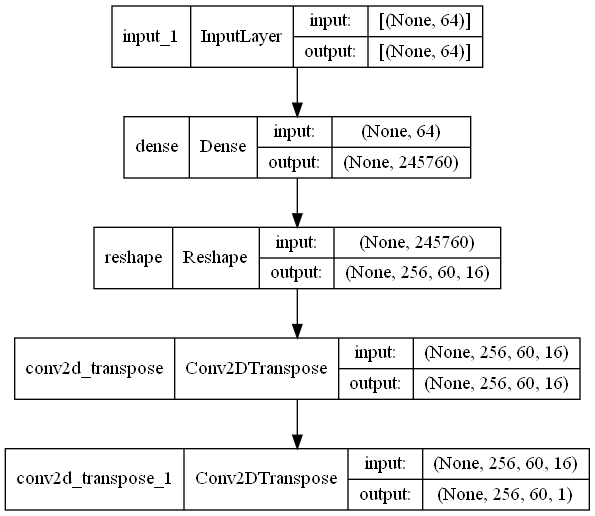

In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape = (noise_dim,)))
    model.add(layers.Dense(len_piece*60*16,activation='tanh'))
    model.add(layers.Reshape(target_shape = (len_piece,60,16)))
    model.add(layers.Conv2DTranspose(16, 3, padding = 'same',activation='tanh'))
    model.add(layers.Conv2DTranspose(1, 3,padding='same'))
    
    return model

generator = make_generator_model()
generator.build()
plot_model(generator,show_shapes=True)

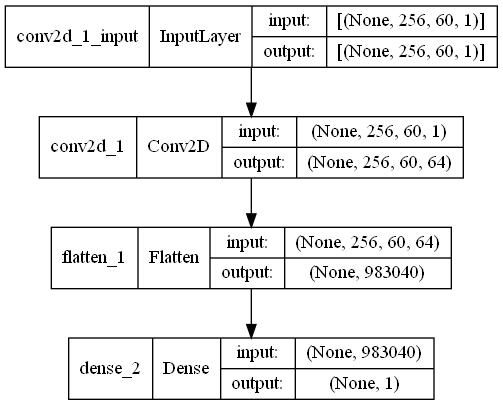

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,3, input_shape = (256,60,1),padding = 'same',activation='tanh'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1,activation = 'sigmoid'))
# 
    return model
discriminator = make_discriminator_model()
discriminator.build()
plot_model(discriminator,show_shapes=True)

In [270]:
#Define discriminator and generator losses
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(5e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-4)

In [272]:
EPOCHS = 10000
num_examples_to_generate = 4

# Seed for generating images
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [273]:
#Training Step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return(gen_loss,disc_loss, real_output, fake_output)

In [274]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss,disc_loss, real_output, fake_output = train_step(image_batch)

    # Produce images for the GIF as you go
    #display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 1000 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {:.4f} is {:.4f} sec'.format(epoch + 1, time.time()-start))
    print ('Generator Loss: {:.4f}, Discriminator Loss: {:.4f}'.format(gen_loss,disc_loss))

  # Generate after the final epoch
  #display.clear_output(wait=True)
  

In [275]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(4):
      plt.subplot(2, 2, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  return(predictions)

In [ ]:
train(train_dataset, EPOCHS)
generated_imgs = generate_and_save_images(generator,
                           EPOCHS,
                           seed)

In [164]:
# generator.save('C:/Users/Amir/Documents/Graduate School/SEP788_789/Project/Models/generator_2.h5')

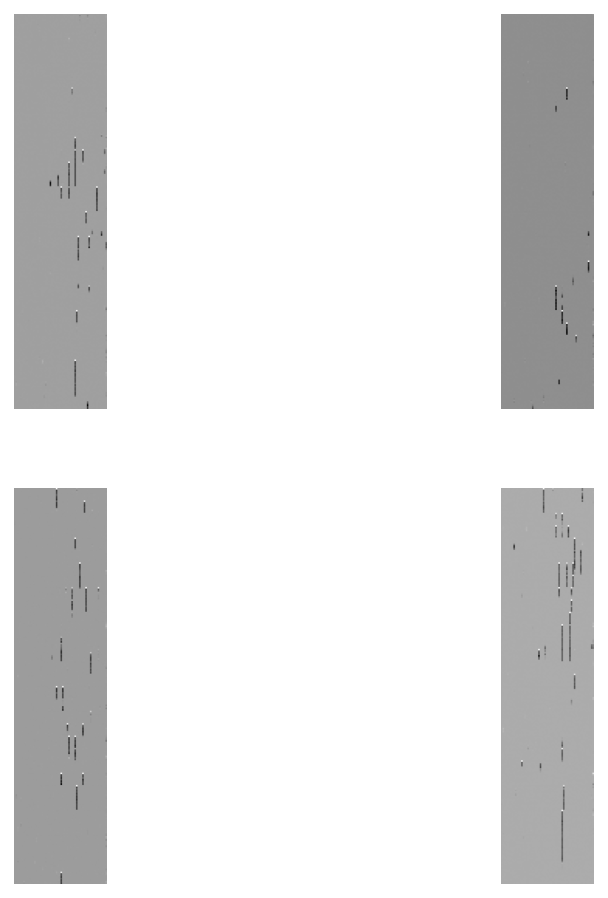

In [181]:
seed2 = tf.random.normal([100, noise_dim])
generated_imgs_2 = generate_and_save_images(generator,
                           100,
                           seed2)

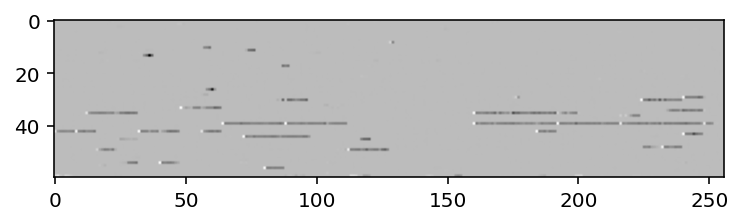

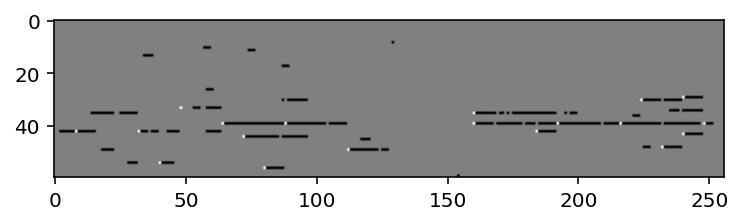

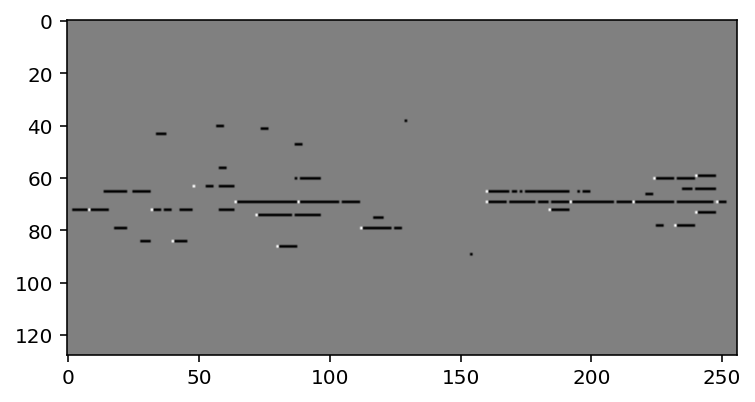

In [177]:
#plt.imshow(generated_imgs_2[1,:,:,0].numpy().transpose())
A = generated_imgs_2[24,:,:,0].numpy()
plt.imshow(A.transpose())
plt.show()
B = np.where(abs(A)>0.7,1*np.sign(A),0)
plt.imshow(tst.transpose())
plt.show()
C = np.append(np.zeros((len_piece,30)),B,axis=1)
C = np.append(a,np.zeros((len_piece,38)),axis=1)
plt.imshow(b.transpose())
plt.gray()
plt.show()


In [178]:
#Reconstruct array back into midi and play
reconMusic(C).show('midi')

In [179]:
#Save midi file
fp = reconMusic(b).write('midi', fp='C:/Users/Amir/Documents/Graduate School/SEP788_789/Project/music_dataset-main/generated_songs/GAN_sample4.mid')

In [50]:
# Reconstruct a song from the multi-hot encoding
def reconMusic(song):
    recon_A = stream.Stream();
    #Insert back the timestamps
    A = np.insert(song,0,np.arange(0,int(len_piece/16),0.0625),axis=1)
    for row in range(A.shape[0]):
        for column in range(1,A.shape[1]):
            if(A[row,column]>0 and row+1<A.shape[0]):
                nt = note.Note()
                nt.pitch.midi = column-1
                ln_strt = 0
                i=1
                val = A[row+1,column]
                while(val <0 and row+i<A.shape[0]):
                    ln_strt=ln_strt+0.0625
                    val = A[row+i,column]
                    i=i+1
                if(row+i == A.shape[0]):
                    ln_strt= ln_strt+0.0625
                nt.quarterLength = ln_strt
                recon_A.append(nt)
                nt.offset = A[row,0]-A[0,0]
    return(recon_A)
